# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.392822,True,8.810747
1,-0.304372,False,-2.969137
2,-0.286937,True,4.497802
3,0.306313,False,1.195031
4,-0.923261,False,-0.863731
...,...,...,...
995,1.030565,True,7.220006
996,-0.047610,False,-0.386622
997,-1.314791,False,-1.153460
998,-1.875311,False,-4.464416


<AxesSubplot: xlabel='v0'>

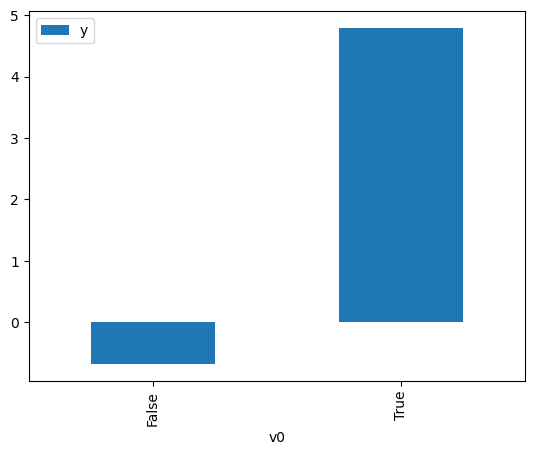

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

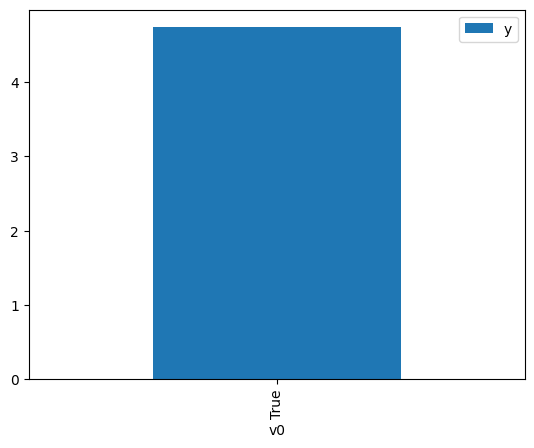

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.457946,False,0.456531,0.353042,2.832524
1,-1.199142,False,-1.833088,0.833501,1.199759
2,-2.015212,False,-5.495126,0.937152,1.067063
3,0.115679,False,0.680316,0.463089,2.159414
4,-1.134460,False,-2.981318,0.821146,1.217810
...,...,...,...,...,...
995,-1.193355,False,-3.384636,0.832424,1.201311
996,0.310917,False,1.120980,0.399141,2.505377
997,0.321507,False,0.041317,0.395749,2.526852
998,-0.226386,False,-1.229558,0.576786,1.733746


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.076595,True,5.988706,0.523892,1.908790
1,-0.818278,True,2.646413,0.249507,4.007898
2,-1.051352,True,4.196008,0.195765,5.108162
3,0.703028,True,6.939862,0.717782,1.393180
4,-0.377090,True,4.071257,0.374922,2.667221
...,...,...,...,...,...
995,-1.191720,True,4.244919,0.167881,5.956584
996,1.699409,True,8.494988,0.906033,1.103712
997,1.084022,True,6.290517,0.808928,1.236203
998,-0.458162,True,3.740624,0.349874,2.858168


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.071e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:32:44   Log-Likelihood:                         -1409.5
No. Observations:                1000   AIC:                                      2823.
Df Residuals:                     998   BIC:                                      2833.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3926      0.032     74.505      0.000       2.330       2.456
x2             4.9167      0.048    102.831      0.000       4.823       5.011
==============================================================================
Omnibus:                        2.318   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                2.128
Skew:                          -0.036   Prob(JB):                        0.345
Kurtosis:                       2.786   Cond. No.                         1.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""